In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from Bio import SeqUtils
from autoamp.finetune import Sequence
from autoamp.finetune import write_fasta
from autoamp.evolve import Esm2ProteinLangaugeModel
from autoamp.evolve import EnsemblePLM
from autoamp.filters import LengthFilter
from autoamp.filters import DAminoAcidsFilter
from autoamp.filters import UnknownAminoAcidsFilter
from autoamp.filters import ChargeFilter
from autoamp.filters import HydrophobicFilter
from autoamp.filters import PHAdjustmentFilter
from autoamp.filters import NTerminalFilter
from autoamp.filters import DisallowedPairsFilter
from autoamp.filters import BetaSheetFilter
from autoamp.filters import DuplicateFilter
from autoamp.filters import FilterChain

In [3]:
# Load the data
df = pd.read_csv("/homes/psetty/projects/master_paper/inputs/dbaasp_complete.csv")

# Remove multimer sequences
df = df[df["COMPLEXITY"] == "Monomer"]

# Remove any rows with nan
df = df.dropna(
    subset=[
        "SEQUENCE", # Stores the actual peptide sequence as a string
        "TARGET GROUP", # Stores the type of bacteria it's effective against (e.g., Gram negative)
        "TARGET ACTIVITY - UNIT", # The units the activity is measure in (ug/ml, uM, nmol/g, µg/g)
        "TARGET ACTIVITY - CONCENTRATION", # The concentration values the experiment was conducted at
        "TARGET ACTIVITY - ACTIVITY MEASURE GROUP", # Whether the activity measure was MIC or IC50
        "TARGET ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)" # The measured target activity
    ]
)

# Remove d-aminoacids
df = df[~df['SEQUENCE'].str.contains('[a-z]')]

# Remove unknown amino acids
df = df[~df['SEQUENCE'].str.contains('X')]

# Make sure none of the sequences have empty strings
df["SEQUENCE"] = [x.replace(" ", "") for x in df["SEQUENCE"]]

# Remove any target activities measured in µg/g 
# There were only a few and they were all 0.0 except for one which was 50.
df = df[df["TARGET ACTIVITY - UNIT"] != "µg/g"]

def convert_activity_units_to_ug_per_ml(row):
    """Convert activity units to ug/ml."""
    # Extract the necessary entries from the dataframe row
    sequence = row["SEQUENCE"]
    unit = row["TARGET ACTIVITY - UNIT"]
    activity = row["TARGET ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)"]

    # If the units are already correct, return early
    if unit == "µg/ml":
        return activity

    # Compute the molecular weight in daltons
    molecular_weight_da = SeqUtils.molecular_weight(sequence, seq_type="protein")

    # This conversion formula is the same whether activity
    # is measure in nmol/g or µM
    return activity * (molecular_weight_da / 1000)
    
# Apply the unit conversion to normalize activity units to ug/ml
df["normalized_activity"] = df.apply(convert_activity_units_to_ug_per_ml, axis=1)

# Only consider MIC activity scores, not IC50
df = df[df["TARGET ACTIVITY - ACTIVITY MEASURE GROUP"] == "MIC"]

# Select the minimum MIC across the different concentration ranges for each sequence
df['min_mic_activity'] = df.groupby('SEQUENCE')['normalized_activity'].transform('min')

# Remove any sequences that are not confirmed to be effective against Gram negative bacteria
df = df[df['TARGET GROUP'].str.contains('Gram-')]

# Now that the min MIC scores are computed, drop the duplicate sequences
df = df.drop_duplicates(subset='SEQUENCE')

/tmp/ipykernel_606088/1949633349.py:2: DtypeWarning: Columns (16,17,23,24,31,32,38,53,54,57,63,64,65,66,67,68,71,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/homes/psetty/projects/master_paper/inputs/dbaasp_complete.csv")


<Axes: >

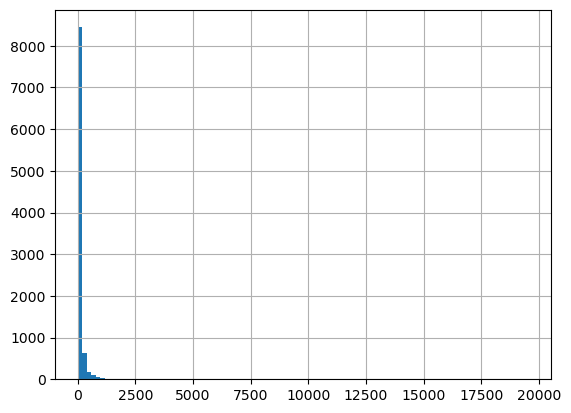

In [4]:
df["min_mic_activity"].hist(bins=100)

<Axes: >

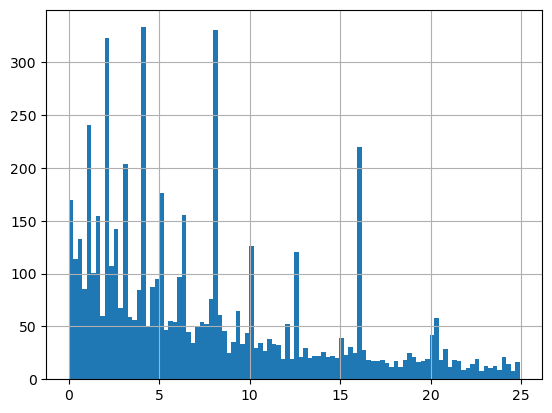

In [5]:
df[df["min_mic_activity"] < 25]["min_mic_activity"].hist(bins=100)

In [6]:
# Filter the data such that only active peptides are present
# Active peptides are defined as having MIC<25 µg/ml and Non-Active peptides as having MIC>100 µg/ml.
df = df[df["min_mic_activity"] < 25]

In [7]:
df.describe()

,ID,INTERCHAIN BOND - CHAIN 1,INTERCHAIN BOND - CHAIN 2,INTERCHAIN BOND - CHAIN 3,INTERCHAIN BOND - CHAIN 4,INTRACHAIN BOND - POSITION 1,INTRACHAIN BOND - POSITION 2,UNUSUAL OR MODIFIED AMINO ACID - POSITION,TARGET ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP),HEMOLITIC CYTOTOXIC ACTIVITY - PH,HEMOLITIC CYTOTOXIC ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP),SYNERGY - PEPTIDE ID,SYNERGY - ANTIBIOTIC ID,SYNERGY - REFERENCE,ARTICLES - YEAR,normalized_activity,min_mic_activity
count,5900.000000,0.0,0.0,0.0,0.0,912.000000,912.000000,0.0,5900.000000,0.0,3.939000e+03,250.000000,47.000000,250.000000,5632.000000,5900.000000,5900.000000
mean,9455.744915,NaN,NaN,NaN,NaN,9.657895,21.709430,NaN,30.883032,NaN,9.418620e+04,9718.372000,8512.936170,2.764000,2010.836648,46.876761,7.476165
std,5982.003917,NaN,NaN,NaN,NaN,9.903556,11.244025,NaN,95.981266,NaN,3.090692e+05,6590.677946,7890.226181,3.437962,63.456696,159.045125,6.178350
min,11.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000775,NaN,0.000000e+00,37.000000,37.000000,1.000000,0.000000,0.000775,0.000250
25%,4110.750000,NaN,NaN,NaN,NaN,3.000000,14.000000,NaN,4.000000,NaN,5.988965e+01,3079.250000,1014.500000,1.000000,2009.000000,5.599999,2.437953
50%,9158.500000,NaN,NaN,NaN,NaN,5.000000,20.000000,NaN,8.900000,NaN,1.577587e+02,8908.500000,8180.000000,1.000000,2014.000000,14.536524,5.766477
75%,14048.750000,NaN,NaN,NaN,NaN,16.000000,29.000000,NaN,23.033764,NaN,3.956695e+02,16524.250000,16951.000000,3.000000,2019.000000,32.000000,11.000000
max,20312.000000,NaN,NaN,NaN,NaN,62.000000,81.000000,NaN,2000.000000,NaN,1.111111e+06,20277.000000,20277.000000,23.000000,2023.000000,5046.139265,24.929381


In [8]:
# Extract the sequences and name tags
sequences = [Sequence(sequence=seq, tag=name) for seq, name in zip(df["SEQUENCE"], df["NAME"])]

In [9]:
sequences[0]

Sequence(sequence='RVKRVWPLVIRTVIAGYNLYRAIKKK', tag='Cathelicidin-1, CATH-1, Fowlicidin-1')

In [10]:
# Setup the filters
filters = [
    LengthFilter(threshold=30), # The dbaasp server only allows predictions up to 30 residues long
    DAminoAcidsFilter(),
    UnknownAminoAcidsFilter(),
    ChargeFilter(threshold=0.25),
    HydrophobicFilter(threshold=0.5),
    PHAdjustmentFilter(threshold=0.75),
    NTerminalFilter(),
    DisallowedPairsFilter(),
    BetaSheetFilter(),
    DuplicateFilter(),
]

# Chain the filters
chain = FilterChain(filters=filters, verbose=True)

print("Sequences before filter:", len(sequences))

# Filter the sequences
sequences = chain.apply(sequences)

print("Sequences after filter:", len(sequences))

Sequences before filter: 5900
Initial number of sequences: 5900
LengthFilter filtered 626
DAminoAcidsFilter filtered 0
UnknownAminoAcidsFilter filtered 0
ChargeFilter filtered 1533
HydrophobicFilter filtered 980
PHAdjustmentFilter filtered 62
NTerminalFilter filtered 25
DisallowedPairsFilter filtered 18
BetaSheetFilter filtered 1921
DuplicateFilter filtered 0
Total filtered: 5165 or 12.46%
Final number of sequences: 735
Sequences after filter: 735


In [11]:
# Setup the mutation models
esm2_8m_base_model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t6_8M_UR50D',
    batch_size=32,
)

esm2_35m_base_model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t12_35M_UR50D',
    batch_size=16,
)

esm2_150m_base_model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t30_150M_UR50D',
    batch_size=4,
)

esm2_650m_base_model = Esm2ProteinLangaugeModel(
    pretrained_model_name_or_path='facebook/esm2_t33_650M_UR50D',
    batch_size=4,
)

# Create the ensemble of protein language models
ensemble = EnsemblePLM(
    models=[
        esm2_8m_base_model,
        esm2_35m_base_model,
        esm2_150m_base_model,
        esm2_650m_base_model,
    ],
    # All the models must agree on the proposed mutation
    consensus_threshold=4,
)

/homes/abrace/.conda/envs/sdl-amp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
# Run the model on the sequences to suggest plausible mutations
mutants = ensemble.infer(sequences)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:07<00:00, 25.82it/s]


In [13]:
print("Predicted mutants:", len(mutants))

Predicted mutants: 30


In [14]:
# Reapply the filters on the mutant sequences
mutants_filtered = set(chain.apply([x.mutated_sequence for x in mutants]))

# Reindex the mutants to exclude the filtered ones
mutants = [x for x in mutants if x.mutated_sequence in mutants_filtered]

print("Filtered mutants:", len(mutants))

Initial number of sequences: 30
LengthFilter filtered 0
DAminoAcidsFilter filtered 0
UnknownAminoAcidsFilter filtered 0
ChargeFilter filtered 0
HydrophobicFilter filtered 0
PHAdjustmentFilter filtered 1
NTerminalFilter filtered 0
DisallowedPairsFilter filtered 0
BetaSheetFilter filtered 0
DuplicateFilter filtered 0
Total filtered: 1 or 96.67%
Final number of sequences: 29
Filtered mutants: 29


In [15]:
# Write a fasta file with the experiment candidates
candidate_sequences = []
for mutant in mutants:
    wildtype_seq = Sequence(sequence=mutant.sequence.sequence, tag=f"wildtype [{mutant.sequence.tag}]")
    mutation_tag = f"p.{mutant.mutation.wildtype}{mutant.mutation.position}{mutant.mutation.mutant}"
    mutant_seq = Sequence(sequence=mutant.mutated_sequence.sequence, tag=f"mutant [{mutant.sequence.tag}] [{mutation_tag}]")
    candidate_sequences.append(wildtype_seq)
    candidate_sequences.append(mutant_seq)

print(f"Writing {len(candidate_sequences)} sequences")

write_fasta(candidate_sequences, "dbaasp_esm2_predicted_candidates_29mutants.fasta")

Writing 58 sequences


In [16]:
# Print the sequences to the notebook
for seq in candidate_sequences:
    print(f">{seq.tag}\n{seq.sequence}")

>wildtype [nan]
KIKGAIKWKGAIKIKGAI
>mutant [nan] [p.W7I]
KIKGAIKIKGAIKIKGAI
>wildtype [nan]
KIGAKIKWGAKIKIGAKI
>mutant [nan] [p.W7I]
KIGAKIKIGAKIKIGAKI
>wildtype [nan]
CVKVRVKVGSGVKVRVKVC
>mutant [nan] [p.C18G]
CVKVRVKVGSGVKVRVKVG
>wildtype [nan]
CFKFKFKFGSGFKFKFKFC
>mutant [nan] [p.C18K]
CFKFKFKFGSGFKFKFKFK
>wildtype [nan]
CWKWKWKWGSGWKWKWKWC
>mutant [nan] [p.C18K]
CWKWKWKWGSGWKWKWKWK
>wildtype [K7LW3]
KLWKKWKKWKK
>mutant [K7LW3] [p.L1K]
KKWKKWKKWKK
>wildtype [R7LW3]
RLWRRWRRWRR
>mutant [R7LW3] [p.L1R]
RRWRRWRRWRR
>wildtype [Theta defensin 1, PhTD1]
RCVCRRGVCRCVCTRGFC
>mutant [Theta defensin 1, PhTD1] [p.T13R]
RCVCRRGVCRCVCRRGFC
>wildtype [Theta defensin 1, PhTD1]
RCVCRRGVCRCVCTRGFC
>mutant [Theta defensin 1, PhTD1] [p.F16V]
RCVCRRGVCRCVCTRGVC
>wildtype [Lfcin-B (1-11)[F1R,K2R,C3W,R4Y,Q7A,K11R]]
RRWYRWAWRMR
>mutant [Lfcin-B (1-11)[F1R,K2R,C3W,R4Y,Q7A,K11R]] [p.Y3R]
RRWRRWAWRMR
>wildtype [GGH-PAP]
GGHKLAKLAKKLAKLAK
>mutant [GGH-PAP] [p.H2K]
GGKKLAKLAKKLAKLAK
>wildtype [PMAP-36 (2-17) [

# Show which residue positions we have mutations for

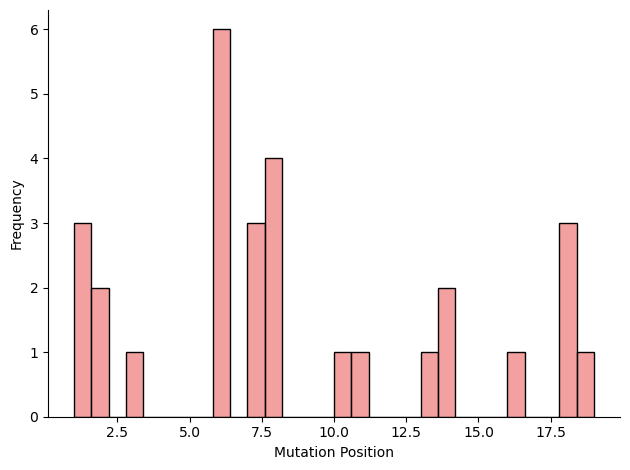

In [17]:
def plot_mutation_positions(mutation_positions):  
    # Histogram for mutation positions
    sns.histplot(mutation_positions, bins=30, color='lightcoral')
    plt.xlabel('Mutation Position')
    plt.ylabel('Frequency')
    
    # Enhance aesthetics
    plt.tight_layout()
    sns.despine()
    plt.show()

mutation_positions = [mutant.mutation.position for mutant in mutants]

plot_mutation_positions(mutation_positions)